## Refining EMP metadata (QIIME mapping files) using Pandas

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime
import math
from collections import defaultdict

In [2]:
pd.set_option("display.max_rows", 200)

In [3]:
pd.options.mode.chained_assignment = None

In [4]:
# path to list of studies (ct112=all) and path to mapping files directory
path_studies = '/Users/luke/emp/metadata-refine/refine_emp_studies_ct112.txt'
path_mapping = '/Users/luke/emp/metadata-qiime-mapping'
path_taxonomy = '/Users/luke/emp/ontology-ncbi-taxonomy/taxdump/names.dmp'
path_empo = '/Users/luke/emp/metadata-refine/empo_samples_unique.xlsx'
path_quality = '/Users/luke/emp/metadata-refine/emp_studies_quality.xlsx'
path_observations = '/Users/luke/emp/otu-picking/emp_observations_97studies.tsv'
path_subsample = '/Users/luke/emp/metadata-refine/modMapping.txt'
path_envobiome = '/Users/luke/emp/ontology-envo/envo_biome_name_is_a.txt'
path_outputdir = '/Users/luke/emp/metadata-refine'

### Functions

#### Merge mapping files and tally column headers

In [5]:
def merge_and_tally_mapping_files(path_studies, path_mapping):
    studies = [line.rstrip('\n') for line in open(path_studies)]
    header_counts = defaultdict(int)
    df_merged = pd.DataFrame()
    for study in studies:
        path = '%s/%s_qiime_mapping.tsv' % (path_mapping, study)
        df_single = pd.read_csv(path, sep='\t', header=0, index_col=0, dtype=str)
        for header in df_single.columns:
            header_counts[header] += 1
        df_merged = df_merged.append(df_single, ignore_index=False, verify_integrity=True)
    return df_merged, header_counts

#### ENVO hierarchy lookup

In [6]:
def term_to_envo_hierarchy(term, dictionary):
    hierarchy = [term]
    while True:
        hierarchy.insert(0, dictionary[term])
        term = dictionary[term]
        if term not in dictionary.keys():
            break
    return hierarchy

def term_parent_to_dict(path):
    # read envo biome file, split into two dataframes, merge, create dictionary
    df = pd.read_csv(path, header=None)
    # name dataframe
    df_name = df.iloc[np.arange(0,df.shape[0],2)]
    df_name.reset_index(inplace=True, drop=True)
    for index, row in df_name.iterrows():
        df_name.iloc[index] = re.sub('name: ', '', str(row[0]))
    # is_a dataframe
    df_is_a = df.iloc[np.arange(1,df.shape[0],2)]
    df_is_a.reset_index(inplace=True, drop=True)
    for index, row in df_is_a.iterrows():
        df_is_a.iloc[index] = re.sub('is_a: ', '', str(row[0]))
    # merged dataframe
    df_name_is_a = pd.merge(df_name, df_is_a, left_index=True, right_index=True)
    df_name_is_a.columns = ['name', 'is_a']
    # dictionary for lookup
    dictionary = dict(zip(df_name_is_a.name, df_name_is_a.is_a))
    return dictionary

#### Remove trailing ".0" from numeric value in column of df (convert string-float to string-int)

In [7]:
def remove_decimal_zero(df, column):
    return [re.sub(r'\.0', '', x) if x is not np.nan else '' for x in df[column]]

#### Round to hundredths with df.apply(round_hundredths)

In [8]:
def round_hundredths(x):
    x = float(x)
    if math.isnan(x):
        return x
    else:
        return "%.2f" % x

#### Convert Fahrenheit to Celsius

In [9]:
def fahrenheit_to_celsius(x):
    x = float(x)
    if math.isnan(x):
        return x
    else:
        return str((x-32)*5/9)

### Read input files and make dictionaries

#### Study quality

In [10]:
df_quality = pd.read_excel(path_quality, index_col=None, dtypes=object)

In [11]:
# dictionary of study_id => title
dict_title = dict(zip(df_quality.study_id.astype(str), df_quality.title))
# dictionary of study_id => ebi_accession
dict_ebi_accession = dict(zip(df_quality.study_id.astype(str), df_quality.ebi_accession))
# dictionary of study_id => emp_paper
dict_emp_paper = dict(zip(df_quality.study_id.astype(str), df_quality.emp_paper))
# dictionary of study_id => dense_sampling
dict_dense_sampling = dict(zip(df_quality.study_id.astype(str), df_quality.dense_sampling))
# dictionary of study_id => metadata_minimal
dict_metadata_minimal = dict(zip(df_quality.study_id.astype(str), df_quality.metadata_minimal))
# dictionary of study_id => units_status
dict_units_status = dict(zip(df_quality.study_id.astype(str), df_quality.units_status))
# dictionary of study_id => study_ok
dict_study_ok = dict(zip(df_quality.study_id.astype(str), df_quality.study_ok))

#### Sequences per sample

In [12]:
df_observations = pd.read_csv(path_observations, sep='\t', index_col=None)

In [13]:
# dictionary of #SampleID => split_libraries
dict_seqs_per_sample = dict(zip(df_observations['#SampleID'], df_observations.split_libraries))

#### Subsampled studies

In [14]:
df_subsample = pd.read_csv(path_subsample, sep='\t', index_col=None)

In [15]:
df_subsample
dict_allemp = dict(zip(df_subsample['#SampleID'], df_subsample.all_emp))
dict_qcfiltered = dict(zip(df_subsample['#SampleID'], df_subsample.qc_filtered))
dict_subset2000 = dict(zip(df_subsample['#SampleID'], df_subsample.subset_2000))
dict_subset5000 = dict(zip(df_subsample['#SampleID'], df_subsample.subset_5000))
dict_subset10000 = dict(zip(df_subsample['#SampleID'], df_subsample.subset_10000))
dict_subset20000 = dict(zip(df_subsample['#SampleID'], df_subsample.subset_20000))

#### NCBI taxonomy

In [16]:
df_tax = pd.read_csv(path_taxonomy, sep='\t\|\t|\t\|', engine='python', header=None)
del df_tax[4]
df_tax.columns = ['tax_id', 'name_txt', 'unique_name', 'name_class']
df_tax['tax_id'] = df_tax['tax_id'].astype(str)

In [17]:
# dictionary of tax_id => genbank common name
df_tax_gcn = df_tax[df_tax['name_class'] == 'genbank common name']
dict_gcn = dict(zip(df_tax_gcn.tax_id, df_tax_gcn.name_txt))

In [18]:
# dictionary of tax_id => scientific name
df_tax_sn = df_tax[df_tax['name_class'] == 'scientific name']
dict_sn = dict(zip(df_tax_sn.tax_id, df_tax_sn.name_txt))

### Read and refine mapping file

#### Read mapping files, tally column headers, and merge into single dataframe

In [19]:
# main code to merge mapping files and count how often column headers appear (~5 min)
df_merged, header_counts = merge_and_tally_mapping_files(path_studies, path_mapping)

In [20]:
# change spaces in indexes to periods (for study 905)
df_merged.index = [re.sub(' ', '.', x) for x in df_merged.index]

In [21]:
# add study_id
df_merged['study_id'] = [re.split(r'\.', x)[0] for x in df_merged.index]

#### Add EMPO columns to merged all columns and select columns (and covert indexes to lowercase to match biom)

In [22]:
df_empo = pd.read_excel(path_empo, index_col=0, dtypes=object)
df_empo.study_id = df_empo.study_id.astype(str)

In [23]:
sampletype_cols = [
    'study_id',
    'env_biome',
    'env_feature',
    'env_matter',
    'sample_type']

In [24]:
df_union_empo = pd.merge(df_merged, df_empo, how='left', left_on=sampletype_cols, right_on=sampletype_cols)
df_union_empo.index = [x for x in df_merged.index]

In [25]:
df_union_empo.to_csv('/Users/luke/emp/metadata-refine/emp_qiime_mapping_union_empo.tsv', sep='\t', index_label='#SampleID')

## Refined mapping file

_Sample_

* `#SampleID` -- no changes needed
* `BarcodeSequence` -- no changes needed
* `LinkerPrimerSequence` -- no changes needed
* `Description` -- no changes needed
* `host_subject_id` -- no changes needed

_Study & quality_

* `study_id` -- parsed from SampleID
* `title` -- using most updated titles (from `emp_studies_quality.xlsx`)
* `ebi_accession` -- EBI accession number if submitted (from `emp_studies_quality.xlsx`)
* `emp_paper` -- included among 97 studies in 2016 EMP paper (TRUE/FALSE, from `emp_studies_quality.xlsx`)
* `study_ok` -- study does not have major issues (from `emp_studies_quality.xlsx`)
* `dense_sampling` -- whether the study has highly similar samples (from `emp_studies_quality.xlsx`)
* `metadata_minimal` -- whether the study has only minimal metadata (from `emp_studies_quality.xlsx`)
* `units_status` -- whether units are provided for measurements (from `emp_studies_quality.xlsx`)

_Subsample_

* `sequences_per_sample` -- number of sequences per sample after split libraries (from `emp_observations_97studies.tsv`)
* `all_emp` -- samples with >=1 sequences per sample
* `qc_filtered` -- samples with >1000 sequences per sample but not controls (all subsets are in this set)
* `subset_2000` -- 2000 samples evenly distributed across `empo_3` categories and then across studies
* `subset_5000` -- 5000 samples evenly distributed across `empo_3` categories and then across studies
* `subset_10000` -- 10000 samples evenly distributed across `empo_3` categories and then across studies
* `subset_20000` -- 20000 samples evenly distributed across `empo_3` categories and then across studies

_Taxonomy_

* `taxon_id` -- removed trailing ".0", fixed Excel Auto Fill and other typos
* `scientific_name` -- deleted values that refer to host or don't match lookup value
* `scientific_name_lookup` -- looked up from names.dmp using `taxon_id`
* `host_taxid` -- removed trailing ".0", fixed Excel Auto Fill typos
* `host_common_name` -- no changes made, but see lookup value
* `host_common_name_lookup` -- looked up from names.dmp using `host_taxid`
* `host_scientific_name_lookup` -- looked up from names.dmp using `host_taxid`

_Geography_

* `collection_timestamp` -- removed timestamps after today's date
* `country` -- fixed misspellings
* `latitude_deg` -- fixed errors
* `longitude_deg` -- fixed errors
* `depth_m` -- no changes made
* `altitude_m` -- no changes made
* `elevation_m` -- no changes made

_Ontology_

* `env_biome` -- fixed errors
* `env_feature` -- no changes made -- need additional changes from gDoc
* `env_material` -- fixed errors, changed name from `env_matter` -- need additional changes from gDoc
* `envo_biome_1` -- level 1 envo biome from `envo_biome_name_is_a.txt`
* `envo_biome_2` -- level 2 envo biome from `envo_biome_name_is_a.txt`
* `envo_biome_3` -- level 3 envo biome from `envo_biome_name_is_a.txt`
* `envo_biome_4` -- level 4 envo biome from `envo_biome_name_is_a.txt`
* `envo_biome_5` -- level 5 envo biome from `envo_biome_name_is_a.txt`
* `envo_biome_6` -- level 6 envo biome from `envo_biome_name_is_a.txt`
* `empo_0` -- no changes, inherited from `emp_qiime_mapping_sampletype_unique_empo.xlsx`
* `empo_1` -- no changes, inherited from `emp_qiime_mapping_sampletype_unique_empo.xlsx`
* `empo_2` -- no changes, inherited from `emp_qiime_mapping_sampletype_unique_empo.xlsx`
* `empo_3` -- no changes, inherited from `emp_qiime_mapping_sampletype_unique_empo.xlsx`

_Environment_

* `temperature_deg_c` -- using `temp`, `temp_environment`, made fully numeric
* `ph` -- using `ph` (fixed), `ph_cacl2`, `sediment_ph`, made fully numeric
* `salinity_psu` -- using `salinity`, `samp_salinity`, `sediment_salinity`, made fully numeric
* `oxygen_mg_per_l` -- no changes made
* `nitrogen spp.`
* `phosphorus spp.`
* `carbon spp.`


### Create dataframe for refined columns

#### Sample metadata

In [102]:
df_refined = pd.DataFrame(index=df_merged.index)
df_refined.index.name = '#SampleID'

In [103]:
df_refined = df_refined.join(df_merged[['BarcodeSequence', 'LinkerPrimerSequence', 'Description', 'host_subject_id']])

#### Study metadata

In [104]:
# adding columns: study_id, title, ebi_accession, emp_paper
df_refined['study_id'] = [re.split(r'\.', x)[0] for x in df_merged.index]
df_refined['title'] = [dict_title[x] if x in dict_title else '' for x in df_refined['study_id']]
df_refined['ebi_accession'] = [dict_ebi_accession[x] if x in dict_ebi_accession else '' for x in df_refined['study_id']]
df_refined['emp_paper'] = [dict_emp_paper[x] if x in dict_emp_paper else '' for x in df_refined['study_id']]
df_refined['study_ok'] = [dict_study_ok[x] if x in dict_study_ok else '' for x in df_refined['study_id']]

#### Quality metadata

In [105]:
# adding columns: dense_sampling, metadata_minimal, units_status, sequences_per_sample, study_ok
df_refined['dense_sampling'] = [dict_dense_sampling[x] if x in dict_dense_sampling else '' for x in df_refined['study_id']]
df_refined['metadata_minimal'] = [dict_metadata_minimal[x] if x in dict_metadata_minimal else '' for x in df_refined['study_id']]
df_refined['units_status'] = [dict_units_status[x] if x in dict_units_status else '' for x in df_refined['study_id']]
df_refined['study_ok'] = [dict_study_ok[x] if x in dict_study_ok else '' for x in df_refined['study_id']]

#### Subsample metadata

In [106]:
df_refined['sequences_per_sample'] = [dict_seqs_per_sample[x] if x in dict_seqs_per_sample else '' for x in df_refined.index]

In [107]:
df_refined['all_emp'] = [dict_allemp[x] if x in dict_allemp else '' for x in df_refined.index]
df_refined['qc_filtered'] = [dict_qcfiltered[x] if x in dict_qcfiltered else '' for x in df_refined.index]
df_refined['subset_2000'] = [dict_subset2000[x] if x in dict_subset2000 else '' for x in df_refined.index]
df_refined['subset_5000'] = [dict_subset5000[x] if x in dict_subset5000 else '' for x in df_refined.index]
df_refined['subset_10000'] = [dict_subset10000[x] if x in dict_subset10000 else '' for x in df_refined.index]
df_refined['subset_20000'] = [dict_subset20000[x] if x in dict_subset20000 else '' for x in df_refined.index]

#### Taxonomy metadata

##### Sample taxonomy

In [108]:
df_refined = df_refined.join(df_merged[['taxon_id', 'scientific_name']])

In [109]:
# taxon_id -- remove trailing ".0"
df_refined['taxon_id'] = remove_decimal_zero(df_refined, 'taxon_id')
# taxon_id -- fix Excel Auto Fill typos
# Study ??
df_refined['taxon_id'][df_merged['taxon_id'] == '718309'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718310'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718311'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718312'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718313'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718314'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718315'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718316'] = '718308'
df_refined['taxon_id'][df_merged['taxon_id'] == '718317'] = '718308'
# Study 10145 -- beach sand metagenome should be 412757
df_refined['taxon_id'][(df_merged['taxon_id'] == '412758') & (df_refined['study_id'] == '10145')] = '412757'
df_refined['taxon_id'][(df_merged['taxon_id'] == '412760') & (df_refined['study_id'] == '10145')] = '412757'
df_refined['taxon_id'][(df_merged['taxon_id'] == '412762') & (df_refined['study_id'] == '10145')] = '412757'
# Study 10278 -- peat metagenome should be 1799672
df_refined['taxon_id'][df_refined['study_id'] == '10278'] = '1799672'

In [110]:
# scientific_name_lookup -- look up from names.dmp using taxon_id 
df_refined['scientific_name_lookup'] = [dict_sn[x] if x in dict_sn else '' for x in df_refined['taxon_id']]

In [111]:
# scientific_name -- delete values that refer to host and not sample
df_refined['scientific_name'][df_refined['study_id'] == '1734'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '1795'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '1889'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10146'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10245'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10273'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10323'] = np.nan

# scientific_name -- delete values that are close but not quite right
df_refined['scientific_name'][df_refined['study_id'] == '10145'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10156'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10180'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10278'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10308'] = np.nan
df_refined['scientific_name'][df_refined['study_id'] == '10346'] = np.nan

In [112]:
# Check that lookup and given values match
# If scientific_name given, does it match lookup value?
df_sample_sn = df_refined[[x is not np.nan for x in df_refined['scientific_name']]][['scientific_name', 'scientific_name_lookup']]
df_sample_sn[df_sample_sn['scientific_name'] != df_sample_sn['scientific_name_lookup']]

,scientific_name,scientific_name_lookup
#SampleID,,


##### Host taxonomy

In [113]:
df_refined = df_refined.join(df_merged[['host_taxid', 'host_common_name']])

In [114]:
# host_taxid -- remove trailing ".0"
df_refined['host_taxid'] = remove_decimal_zero(df_refined, 'host_taxid')
# host_taxid -- fix Excel Auto Fill typos
# Study 10180 -- all should be soil metagenome (410658)
df_refined['host_taxid'][df_refined['study_id'] == '10180'] = '410658'
# Study 1747 -- Komodo dragons should be 61221
df_refined['host_taxid'][(df_merged['host_taxid'] == '61222') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61223') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61224') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61225') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61226') & (df_refined['study_id'] == '1747')] = '61221'
df_refined['host_taxid'][(df_merged['host_taxid'] == '61227') & (df_refined['study_id'] == '1747')] = '61221'
# Study 1056 -- Nine-banded armadillio should be 9361
df_refined['host_taxid'][df_refined['host_common_name'] == 'Nine-banded armadillo'] = '9361'

In [115]:
# host_common_name_lookup -- look up from names.dmp using host_taxid 
df_refined['host_common_name_lookup'] = [dict_gcn[x] if x in dict_gcn else '' for x in df_refined['host_taxid']]
# host_scientific_name_lookup -- look up from names.dmp using host_taxid 
df_refined['host_scientific_name_lookup'] = [dict_sn[x] if x in dict_sn else '' for x in df_refined['host_taxid']]

#### Geography metadata

In [116]:
# collection_timestamp
today = datetime.datetime.today()
df_merged['collection_timestamp'][df_merged['collection_timestamp'] == 'Missing: Not provided'] = ''
df_refined['collection_timestamp'] = (df_merged['collection_timestamp'][(df_merged['collection_timestamp'].apply(pd.Timestamp) < today)]).apply(pd.Timestamp)
# country
df_refined['country'] = df_merged['country']
# fix misspellings
df_refined['country'][df_merged['country'] == 'USA'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'GAZ:USA'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'GAZ: United states of america'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'GAZ:United Staates of America'] = 'GAZ:United States of America'
df_refined['country'][df_merged['country'] == 'Kenya'] = 'GAZ:Kenya'
df_refined['country'][df_merged['country'] == 'Canada'] = 'GAZ:Canada'
df_refined['country'][df_merged['country'] == 'GAZ:Arctic ocean'] = 'GAZ:Arctic Ocean'
df_refined['country'][df_merged['country'] == 'GAZ:russia'] = 'GAZ:Russia'
df_refined['country'][df_merged['country'] == 'GAZ:Commonwealth of Puerto Rico'] = 'GAZ:Puerto Rico'

In [117]:
# latitude, longitude
df_refined['latitude_deg'] = df_merged['latitude']
df_refined['longitude_deg'] = df_merged['longitude']
# change 0.0 to NaN (studies 1197, 1526, 1632, 1665, 1734, 1883)
df_refined['latitude_deg'][df_merged['latitude'] == '0.0'] = np.nan
df_refined['longitude_deg'][df_merged['longitude'] == '0.0'] = np.nan
# change 9999.0 to NaN (study 10156)
df_refined['latitude_deg'][df_merged['latitude'] == '9999.0'] = np.nan
df_refined['longitude_deg'][df_merged['longitude'] == '9999.0'] = np.nan
# divide by 100 for value > 10000 (study 933) -- Gail will fix in Qiita
for index, value in df_merged['longitude'].iteritems():
    if float(value) > 10000:
        df_refined['longitude_deg'][index] = str(float(value)*0.01)

In [118]:
# depth, altitude, and elevation
df_refined['depth_m'] = df_merged['depth']
df_refined['altitude_m'] = [float(x) * 1000 for x in df_merged['altitude']]
df_refined['elevation_m'] = df_merged['elevation']

#### Ontology metadata

##### ENVO ontology

In [119]:
# env_biome, env_feature, env_material
# gdoc: https://docs.google.com/spreadsheets/d/1Xqmelnbx5PahFh4PoWEOo4zup9qwg52GR82Jrj313Os/edit?usp=sharing
df_refined['env_biome'] = df_merged['env_biome']
df_refined['env_feature'] = df_merged['env_feature']
df_refined['env_material'] = df_merged['env_matter']

# env_biome fixes
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:large lake biome'] = 'ENVO:Large lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:large river biome'] = 'ENVO:Large river biome'
df_refined['env_biome'][df_merged['env_biome'] == 'large river biome'] = 'ENVO:Large river biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:small lake biome'] = 'ENVO:Small lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVOSmall lake biome'] = 'ENVO:Small lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'small lake biome'] = 'ENVO:Small lake biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:small river biome'] = 'ENVO:Small river biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:small river biome biome'] = 'ENVO:Small river biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:cropland'] = 'ENVO:cropland biome'
df_refined['env_biome'][df_merged['env_biome'] == 'estuarine biome'] = 'ENVO:estuarine biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:flooded grassland'] = 'ENVO:flooded grassland biome'
df_refined['env_biome'][df_merged['env_biome'] == 'marginal sea'] = 'ENVO:marginal sea biome'
df_refined['env_biome'][df_merged['env_biome'] == 'marine benthic biome'] = 'ENVO:marine benthic biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:mediterranean forests, woodlands, and shrub biome'] = 'ENVO:mediterranean woodland biome'
df_refined['env_biome'][df_merged['env_biome'] == 'ENVO:temperate grassland'] = 'ENVO:temperate grassland biome'
# Study 723 should be 'marine pelagic biome' instead of 'polar biome'
df_refined['env_biome'][df_refined['study_id'] == '723'] = 'ENVO:marine pelagic biome'
# Studies 776, 1033 should be 'polar desert biome' instead of 'polar biome'
df_refined['env_biome'][df_refined['study_id'] == '776'] = 'ENVO:polar desert biome'
df_refined['env_biome'][df_refined['study_id'] == '1033'] = 'ENVO:polar desert biome'
# Studies 1036 should be 'tundra biome' instead of 'polar biome'
df_refined['env_biome'][df_refined['study_id'] == '1036'] = 'ENVO:tundra biome'
# Study 632 reassign defunct categories
df_refined['env_biome'][(df_refined['study_id'] == '632') & (df_refined['env_biome'] == 'ENVO:temperate broadleaf and mixed forest biome')] = 'ENVO:temperate mixed forest biome'
df_refined['env_biome'][(df_refined['study_id'] == '632') & (df_refined['env_biome'] == 'ENVO:temperate grasslands, savannas, and shrubland biome')] = 'ENVO:temperate grassland biome'
# Study 1521 reassign defunct categories
df_refined['env_biome'][(df_refined['study_id'] == '1521') & (df_refined['env_biome'] == 'ENVO:temperate broadleaf and mixed forest biome')] = 'ENVO:temperate mixed forest biome'
# Study 1037 reassign defunct categories
df_refined['env_biome'][(df_refined['study_id'] == '1037') & (df_refined['env_biome'] == 'ENVO:temperate grasslands, savannas, and shrubland biome')] = 'ENVO:temperate grassland biome'

# env_feature fixes -- NOT DONE, lots of questionable classifications -- see gDoc

# env_material fixes -- still need to reassign several -- see highlighted rows in gDoc
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:egg'] = 'ENVO:avian egg product'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:oraganic material'] = 'ENVO:organic material'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:organic material feature'] = 'ENVO:organic material'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO:surface'] = 'ENVO:surface layer'
df_refined['env_material'][df_merged['env_matter'] == 'sea water'] = 'ENVO:sea water'
df_refined['env_material'][df_merged['env_matter'] == 'marine sediment'] = 'ENVO:marine sediment'
df_refined['env_material'][df_merged['env_matter'] == 'estuary water'] = 'ENVO:estuary water'
df_refined['env_material'][df_merged['env_matter'] == 'fresh water'] = 'ENVO:fresh water'
df_refined['env_material'][df_merged['env_matter'] == 'hypersaline water'] = 'ENVO:hypersaline water'
df_refined['env_material'][df_merged['env_matter'] == 'sediment'] = 'ENVO:sediment'
df_refined['env_material'][df_merged['env_matter'] == 'fresh water sediment'] = 'ENVO:lake sediment'
df_refined['env_material'][df_merged['env_matter'] == 'ENVO: freshwater sediment'] = 'ENVO:lake sediment'
df_refined['env_material'][df_merged['env_matter'] == 'estuary sediment'] = 'ENVO:estuary sediment'

# removing "ENVO:"
df_refined['env_biome'] = [re.sub('ENVO:', '', string) for string in df_refined['env_biome']]
df_refined['env_feature'] = [re.sub('ENVO:', '', string) for string in df_refined['env_feature']]
df_refined['env_material'] = [re.sub('ENVO:', '', string) for string in df_refined['env_material']]

##### ENVO biome hierarchy (input files from Jad's envo_ontology_parsing.sh)

In [120]:
# add ENVO biome hierarchy
dict_name_is_a = term_parent_to_dict(path_envobiome)
df_refined['envo_biome_1'] = [term_to_envo_hierarchy(x, dict_name_is_a)[1] if x in dict_name_is_a else np.nan for x in df_refined['env_biome']]
df_refined['envo_biome_2'] = [term_to_envo_hierarchy(x, dict_name_is_a)[2] if x in dict_name_is_a else np.nan for x in df_refined['env_biome']]
df_refined['envo_biome_3'] = [term_to_envo_hierarchy(x, dict_name_is_a)[3] if ((x in dict_name_is_a) & (len(term_to_envo_hierarchy(x, dict_name_is_a)) > 3)) else np.nan for x in df_refined['env_biome']]
df_refined['envo_biome_4'] = [term_to_envo_hierarchy(x, dict_name_is_a)[4] if ((x in dict_name_is_a) & (len(term_to_envo_hierarchy(x, dict_name_is_a)) > 4)) else np.nan for x in df_refined['env_biome']]
df_refined['envo_biome_5'] = [term_to_envo_hierarchy(x, dict_name_is_a)[5] if ((x in dict_name_is_a) & (len(term_to_envo_hierarchy(x, dict_name_is_a)) > 5)) else np.nan for x in df_refined['env_biome']]
df_refined['envo_biome_6'] = [term_to_envo_hierarchy(x, dict_name_is_a)[6] if ((x in dict_name_is_a) & (len(term_to_envo_hierarchy(x, dict_name_is_a)) > 6)) else np.nan for x in df_refined['env_biome']]

##### EMPO sample type ontology

In [121]:
# Specified directly by Excel file, where EMPO categories are manually assigned to 
# each unique combination of env_biome, env_feature, env_matter, and sample_type.
df_refined = df_refined.join(df_union_empo[['empo_0', 'empo_1', 'empo_2', 'empo_3']])

In [122]:
# Study 1627: 5 samples are "Sediment (non-saline)" not "Sediment (saline)" (change empo_3 and empo_2)
df_refined['empo_3']['1627.GZC'] = 'Sediment (non-saline)'
df_refined['empo_2']['1627.GZC'] = 'Non-saline'

df_refined['empo_3']['1627.BGC'] = 'Sediment (non-saline)'
df_refined['empo_2']['1627.BGC'] = 'Non-saline'

df_refined['empo_3']['1627.LC'] = 'Sediment (non-saline)'
df_refined['empo_2']['1627.LC'] = 'Non-saline'

df_refined['empo_3']['1627.SMXC'] = 'Sediment (non-saline)'
df_refined['empo_2']['1627.SMXC'] = 'Non-saline'

df_refined['empo_3']['1627.RWC'] = 'Sediment (non-saline)'
df_refined['empo_2']['1627.RWC'] = 'Non-saline'

#### Environment metadata

In [123]:
# temperature -- using temp, temp_environment
df_refined['temperature_deg_c'] = df_merged['temp']
# change None and No data to np.nan
df_refined['temperature_deg_c'][df_merged['temp'] == 'None'] = np.nan
df_refined['temperature_deg_c'][df_merged['temp'] == 'No data'] = np.nan
# use temp_environment if refined temperature is NaN
df_refined['temperature_deg_c'][(df_refined['temperature_deg_c']).isnull()] = df_merged['temp_enviromnment'][(df_refined['temperature_deg_c']).isnull()]
# remove '0.0' values for Study 10247
df_refined['temperature_deg_c'][(df_refined['temperature_deg_c'] == '0.0') & (df_refined['study_id'] == '10247')] = np.nan
# convert Fahrenheit to Celsius for Study 2300
df_refined['temperature_deg_c'][df_refined['study_id'] == '2300'] = df_refined['temperature_deg_c'][df_refined['study_id'] == '2300'].apply(fahrenheit_to_celsius)

In [124]:
# ph -- using ph, ph_cacl2, and sediment_ph
df_refined['ph'] = df_merged['ph']
# change None and NaN to np.nan
df_refined['ph'][df_merged['ph'] == 'NaN'] = np.nan
df_refined['ph'][df_merged['ph'] == 'None'] = np.nan
# change 9999.0 to NaN
df_refined['ph'][df_merged['ph'] == '9999.0'] = np.nan
# change 8.08 +- 0.21 to 8.08
df_refined['ph'][df_merged['ph'] == '8.08 +- 0.21'] = '8.08'
# round ph for Study 10246 to hundredths place
df_refined['ph'][df_refined['study_id'] == '10246'] = df_refined['ph'][df_refined['study_id'] == '10246'].apply(round_hundredths)
# pull ph from oxygen_percent if #SampleID starts with 945 and lake == Fuchskuhle -- Gail will fix in Qiita
df_refined['ph'][df_merged['lake'] == 'Fuchskuhle'] = df_merged[df_merged['lake'] == 'Fuchskuhle']['oxygen_percent']
# use ph_cacl2 if refined ph is NaN
df_refined['ph'][(df_refined['ph']).isnull()] = df_merged['ph_cacl2'][(df_refined['ph']).isnull()]
# use sediment_ph if refined ph is still NaN
df_refined['ph'][(df_refined['ph']).isnull()] = df_merged['sediment_ph'][(df_refined['ph']).isnull()]

In [125]:
# salinity -- using salinity, samp_salinity, sediment_salinity
df_refined['salinity_psu'] = df_merged['salinity']
# change None to np.nan
df_refined['salinity_psu'][df_merged['salinity'] == 'None'] = np.nan
# use samp_salinity if refined salinity is NaN
df_refined['salinity_psu'][(df_refined['salinity_psu']).isnull()] = df_merged['samp_salinity'][(df_refined['salinity_psu']).isnull()]
# use sediment_salinity if refined salinity is NaN
df_refined['salinity_psu'][(df_refined['salinity_psu']).isnull()] = df_merged['sediment_salinity'][(df_refined['salinity_psu']).isnull()]
# covert ppm to ppt for 3 samples in Study 10145
df_refined['salinity_psu']['10145.NB.1A'] = '0.0657'
df_refined['salinity_psu']['10145.7th.1A'] = '0.199'
df_refined['salinity_psu']['10145.7th.1C'] = '0.831'
# remove '0.0' values for Study 10247
df_refined['salinity_psu'][(df_refined['salinity_psu'] == '0.0') & (df_refined['study_id'] == '10247')] = np.nan

In [126]:
# oxygen
df_refined['oxygen_mg_per_l'] = df_merged['oxygen']

### Additional metadata columns (from Fauzi)

### Hierarchical taxonomy lookup (from Jon)

https://github.com/tanaes/script_bin/blob/master/humann2_full_tax.py#L170

You need to:

    from ete2 import NCBITaxa
    ncbi = NCBITaxa()
    lineage = get_taxon_path(best_id, ncbi, ranks=ranks, rank_headers=rank_headers)

### List of studies with counts by empo_3 (minus blanks)

In [127]:
# filter out controls
df_refined_no_controls = df_refined[df_refined['empo_1'] != 'Control']

In [128]:
# count the number of samples per study_id/title and empo_3 (use BarcodeSequence to get the count)
studies_groupby = df_refined_no_controls.groupby(['study_id', 'title', 'empo_3']).count()
studies_groupby_unstack = studies_groupby['BarcodeSequence'].unstack()

In [129]:
# add sum column
studies_groupby_unstack['Total'] = studies_groupby_unstack.sum(axis=1)

In [130]:
# reorder columns
cols = ['Total',
        'Animal corpus', 
        'Animal distal gut', 
        'Animal proximal gut', 
        'Animal secretion', 
        'Animal surface', 
        'Plant corpus', 
        'Plant rhizosphere', 
        'Plant surface', 
        'Soil (non-saline)', 
        'Sediment (non-saline)', 
        'Surface (non-saline)', 
        'Water (non-saline)', 
        'Aerosol (non-saline)', 
        'Sediment (saline)', 
        'Surface (saline)', 
        'Water (saline)',
        'Intertidal (saline)', 
        'Hypersaline (saline)']
studies_groupby_unstack = studies_groupby_unstack[cols]

In [131]:
studies_groupby_unstack = pd.DataFrame(data=studies_groupby_unstack.fillna(0), dtype=int)
studies_groupby_unstack_sorted = studies_groupby_unstack['Total'].sort_values(ascending=False)

##### Result: Samples per study

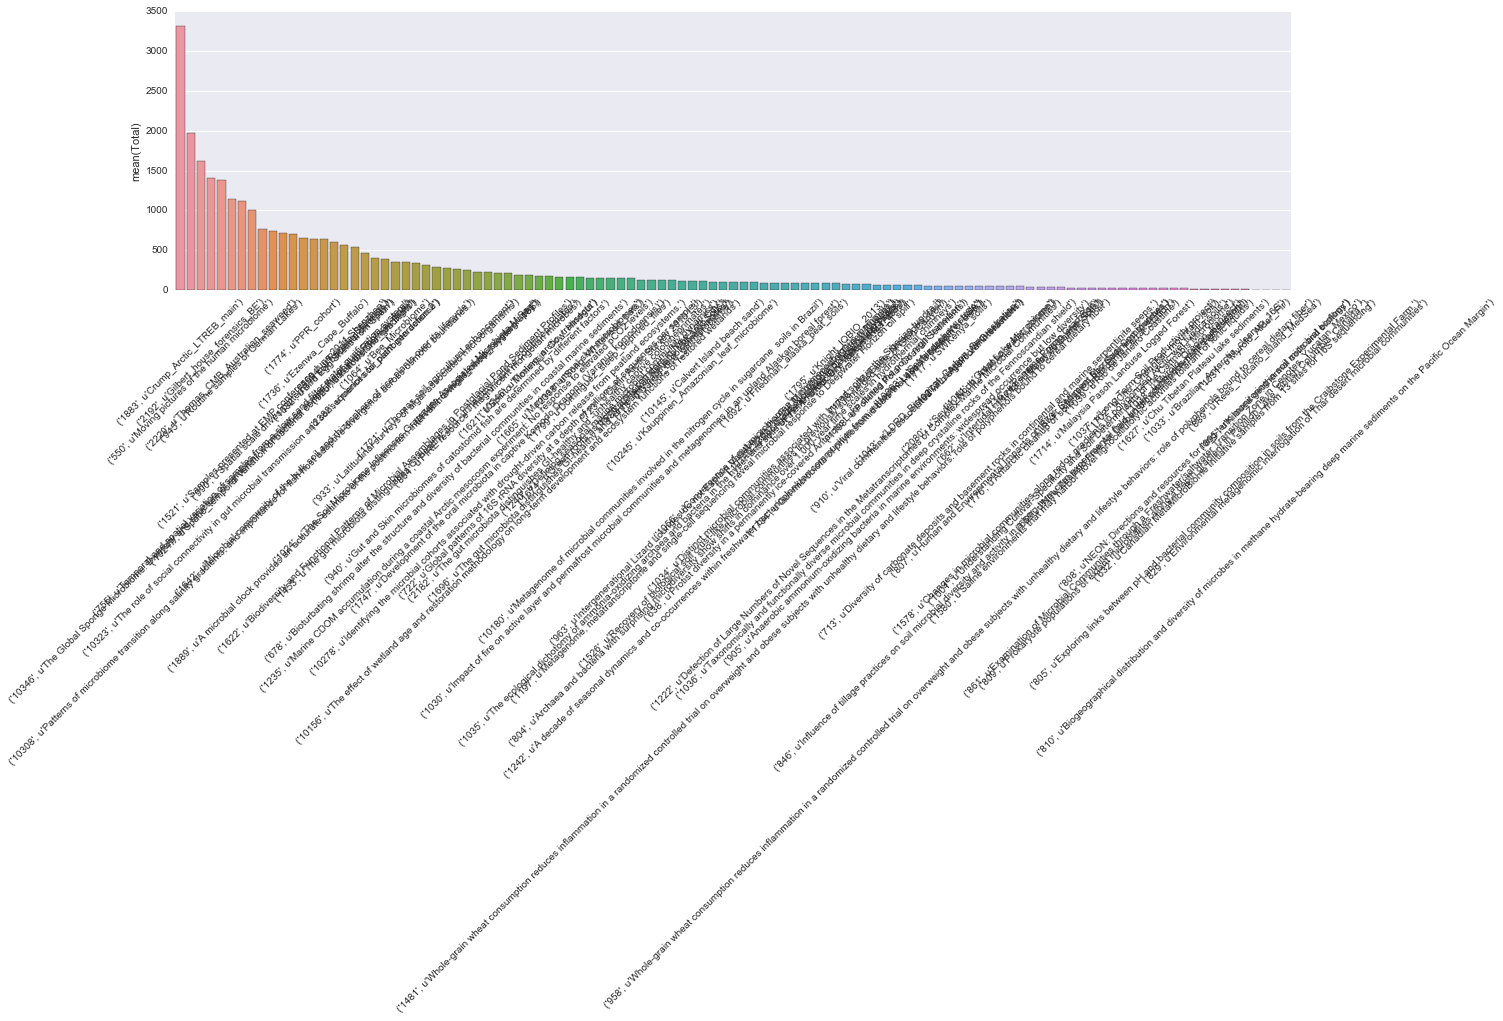

In [132]:
plt.figure(figsize=(20,5))
ph = sns.barplot(studies_groupby_unstack_sorted.index, studies_groupby_unstack_sorted)
for item in ph.get_xticklabels():
    item.set_rotation(45)

### Write merged refined mapping file

In [133]:
today = datetime.datetime.today()
df_refined.to_csv('%s/emp_qiime_mapping_refined_%s.tsv' % (path_outputdir, today.strftime('%Y%m%d')), sep='\t')

In [134]:
# write qc-filtered mapping file
df_refined[df_refined.qc_filtered == True].to_csv('%s/emp_qiime_mapping_refined_%s_qc.tsv' % (path_outputdir, today.strftime('%Y%m%d')), sep='\t')

### Write list of studies

In [135]:
studies_groupby_unstack.to_csv('%s/emp_studies_no_controls_%s.tsv' % (path_outputdir, today.strftime('%Y%m%d')), sep='\t')

### Split and write individual refined mapping files

In [136]:
studies = [line.rstrip('\n') for line in open(path_studies)]
for study in studies:
    df_individual = df_refined[df_refined.study_id == study]
    df_individual.to_csv('%s/qiime-maps-refined/%s_qiime_mapping_refined.tsv' % (path_outputdir, study), sep='\t')